# Handwritten digit recognition using Pytorch

In [1]:
#pip install torch

In [2]:
#pip install torchvision numpy matplotlib

In [40]:
import torch
import torch.nn as nn
from torch.optim import SGD
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy

Download from www.di.ens.fr/~lelarge/MNIST.tar.gz

In [41]:
!ls MNIST

processed  raw


In [45]:
x, y = torch.load('/home/wes-237b/MNIST/MNIST/processed/training.pt')

In [46]:
x.shape

torch.Size([60000, 28, 28])

In [47]:
y.shape

torch.Size([60000])

torch.Size([28, 28])
tensor(4)


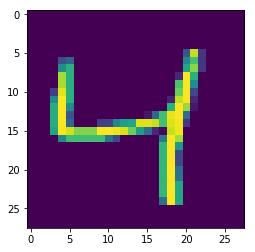

In [48]:
plt.imshow(x[2])
print(x[2].shape)
print(y[2])

# PyTorch Dataset Object

In [49]:
class MnistDataset(Dataset):
    def __init__(self, filepath):
        self.x, self.y = torch.load(filepath)
        self.x = self.x / 255.
        self.y = F.one_hot(self.y, num_classes=10).to(float)
        
    def __len__(self): 
        return self.x.shape[0]
    
    def __getitem__(self, ix): 
        return self.x[ix], self.y[ix]

In [50]:
train_ds = MnistDataset('/home/wes-237b/MNIST/MNIST/processed/training.pt')
test_ds = MnistDataset('/home/wes-237b/MNIST/MNIST/processed/test.pt')

In [51]:
len(train_ds)

60000

In [52]:
train_ds[0][1]

tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=torch.float64)

In [53]:
xs, ys = train_ds[0:4]

In [54]:
ys.shape

torch.Size([4, 10])

# PyTorch DataLoader Object

We can then put the `Dataset` objects inside a `DataLoader` class. This is useful because we can specify a `batch_size`. Each iteration through the dataloader will yield a tensor where the first dimension is equal to the `batch_size`.

In [13]:
train_dl = DataLoader(train_ds, batch_size=5)

In [14]:
for x, y in train_dl:
    print(x.shape)
    print(y.shape)
    break

torch.Size([5, 28, 28])
torch.Size([5, 10])


Since the `batch_size` here is 5, and there are 60000 images, the length of the `DataLoader` object should be 12000.

In [15]:
len(train_dl)

12000

# Cross Entropy Loss

In [26]:
L = nn.CrossEntropyLoss()

# The Network

In [55]:
class MyNeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.Matrix1 = nn.Linear(28**2,100)
        self.Matrix2 = nn.Linear(100,50)
        self.Matrix3 = nn.Linear(50,10)
        self.R = nn.ReLU()
    def forward(self,x):
        x = x.view(-1,28**2)
        x = self.R(self.Matrix1(x))
        x = self.R(self.Matrix2(x))
        x = self.Matrix3(x)
        return x.squeeze()

In [56]:
f = MyNeuralNet()

In [57]:
f

MyNeuralNet(
  (Matrix1): Linear(in_features=784, out_features=100, bias=True)
  (Matrix2): Linear(in_features=100, out_features=50, bias=True)
  (Matrix3): Linear(in_features=50, out_features=10, bias=True)
  (R): ReLU()
)

# Training

In [58]:
def train_model(dl, f, n_epochs=20):
    # Optimization
    opt = SGD(f.parameters(), lr=0.01)
    L = nn.CrossEntropyLoss()

    # Train model
    losses = []
    epochs = []
    for epoch in range(n_epochs):
        print(f'Epoch {epoch}')
        N = len(dl)
        for i, (x, y) in enumerate(dl):
            # Update the weights of the network
            opt.zero_grad() 
            loss_value = L(f(x), y) 
            loss_value.backward() 
            opt.step() 
            # Store training data
            epochs.append(epoch+i/N)
            losses.append(loss_value.item())
    return np.array(epochs), np.array(losses)

In [59]:
epoch_data, loss_data = train_model(train_dl, f)

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19


In [62]:
epoch_data_avgd = epoch_data.reshape(20,-1).mean(axis=1)
loss_data_avgd = loss_data.reshape(20,-1).mean(axis=1)

Text(0.5,1,'Cross Entropy (avgd per epoch)')

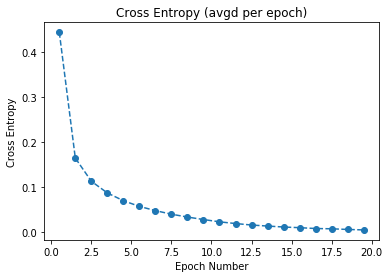

In [63]:
plt.plot(epoch_data_avgd, loss_data_avgd, 'o--')
plt.xlabel('Epoch Number')
plt.ylabel('Cross Entropy')
plt.title('Cross Entropy (avgd per epoch)')

In [44]:
torch.save(f.state_dict(), '/home/wes-237b/MNIST/Pytorch_MNIST_Model.pt')

# Testing

In [64]:
xs, ys = train_ds[0:2000]
yhats = f(xs).argmax(axis=1)

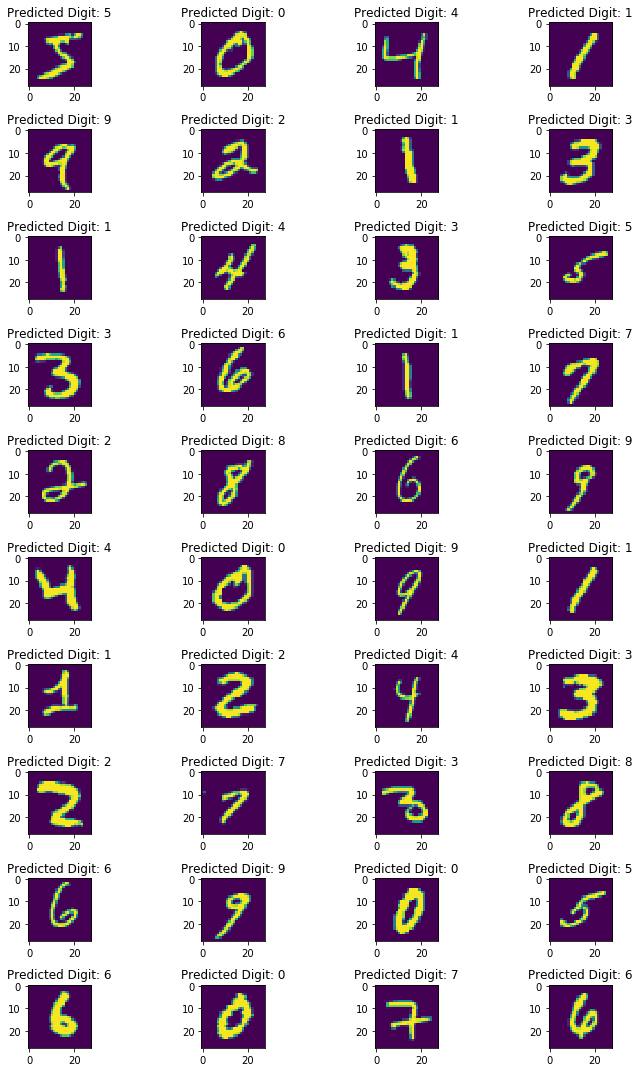

In [65]:
fig, ax = plt.subplots(10,4,figsize=(10,15))
for i in range(40):
    plt.subplot(10,4,i+1)
    plt.imshow(xs[i])
    plt.title(f'Predicted Digit: {yhats[i]}')
fig.tight_layout()
plt.show()

# Handwritten digit detection

In [66]:
import cv2
import os
IMG_DIR = "/home/wes-237b/MNIST/data/h_test"

In [67]:

def get_tensor_from_test_img(img):
    img_arr = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
    img_arr = ~img_arr
    
    resized_img = cv2.resize(img_arr, (28, 28))
    resized_img = resized_img.astype(np.float32)
    resized_img_tensor = torch.from_numpy(resized_img)
    return resized_img_tensor

def get_tensor_from_test_dir(IMG_DIR):
    img_tensor_list = []
    for img in os.listdir(IMG_DIR):
        img_tensor_list.append(get_tensor_from_test_img(os.path.join(IMG_DIR, img)))
    return img_tensor_list


In [68]:
img_tensors = get_tensor_from_test_dir(IMG_DIR)

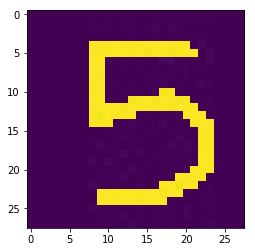

In [69]:
plt.imshow(img_tensors[0])

In [70]:
print(torch.argmax(f(img_tensors[0])))

tensor(5)


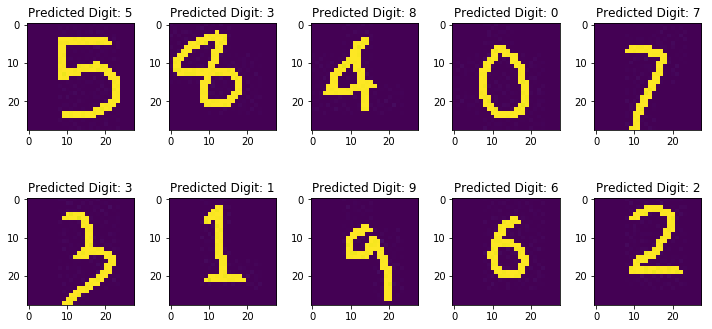

In [71]:
   
fig, ax = plt.subplots(10,5,figsize=(10,5))
for i in range(len(img_tensors)):
    plt.subplot(2,5,i+1)
    plt.imshow(img_tensors[i])
    plt.title(f'Predicted Digit: {torch.argmax(f(img_tensors[i]))}')
fig.tight_layout()
plt.show()